## Setup

In [1]:
!sudo apt-get install libsox-dev --quiet

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libao-common libao4 libid3tag0 libmad0 libopencore-amrnb0 libopencore-amrwb0
  libsox-fmt-all libsox-fmt-alsa libsox-fmt-ao libsox-fmt-base libsox-fmt-mp3
  libsox-fmt-oss libsox-fmt-pulse libsox3 libwavpack1
Suggested packages:
  libaudio2 libsndio6.1
The following NEW packages will be installed:
  libao-common libao4 libid3tag0 libmad0 libopencore-amrnb0 libopencore-amrwb0
  libsox-dev libsox-fmt-all libsox-fmt-alsa libsox-fmt-ao libsox-fmt-base
  libsox-fmt-mp3 libsox-fmt-oss libsox-fmt-pulse libsox3 libwavpack1
0 upgraded, 16 newly installed, 0 to remove and 49 not upgraded.
Need to get 1,053 kB of archives.
After this operation, 4,061 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libao-common all 1.2.2+20180113-1.1ubuntu3 [6,568 B]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libao4 a

In [2]:
!pip install datasets sox --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
# Connect to Drive repository
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import torch, datasets, json, torchaudio, os, math, pathlib, random, itertools
import numpy as np
from tqdm import tqdm

#### Get WAV paths

In [5]:
!unzip -q drive/MyDrive/MLMI2/raw_data/wav/TRAIN.zip -d .

In [6]:
# Get paths to training WAV samples
with open('drive/MyDrive/MLMI2/proc_data/json/train.json', 'r') as f:
    data = json.load(f)
    train_wav_paths = [i['wav'].replace('wav/', '') for i in data]

## Class imbalance analysis

In [7]:
def get_phone_counts(data):
  phone_counts = {}
  for sample in data:
    for phone in sample['phn'].split(' '):
      if phone not in phone_counts:
        phone_counts[phone] = 1
      else:
        phone_counts[phone] += 1
  return phone_counts

def get_scored_data(data, scoring):
  data_scores = []
  score_phones = lambda phones: sum([scoring[phn] for phn in phones])

  for idx, sample in enumerate(data):
    sample_score = score_phones(sample['phn'].split(' '))
    data_scores.append((idx, sample_score))

  # Sort list based on score
  data_scores = sorted(data_scores, key=lambda x: x[1], reverse=True)
  return data_scores

In [8]:
phone_counts = get_phone_counts(data)

sorted_phone_counts = dict(sorted(phone_counts.items(), key=lambda item: item[1], reverse=False))
scoring = {k: 1/(v/sum(sorted_phone_counts.values())) for k,v in sorted_phone_counts.items()}
print(sorted_phone_counts)

scored_data = get_scored_data(data, scoring)

# Augment by 20%
augmented_data = data.copy()
for _ in range(2):
  for sample_id in scored_data[:int(len(scored_data)*0.15)]:
    augmented_data.append(data[sample_id[0]])

augmented_phone_counts = get_phone_counts(augmented_data)

sorted_augmented_phone_counts = dict(sorted(augmented_phone_counts.items(), key=lambda item: item[1], reverse=False))
augmented_scoring = {k: 1/(v/sum(sorted_augmented_phone_counts.values())) for k,v in sorted_augmented_phone_counts.items()}
print(sorted_augmented_phone_counts)

scored_augmented_data = get_scored_data(augmented_data, augmented_scoring)

{'oy': 304, 'uh': 500, 'aw': 728, 'th': 745, 'ch': 820, 'y': 995, 'jh': 1013, 'g': 1191, 'ng': 1220, 'sh': 1466, 'ow': 1653, 'hh': 1660, 'dx': 1864, 'ay': 1934, 'uw': 1952, 'v': 1994, 'b': 2181, 'f': 2215, 'w': 2216, 'ey': 2271, 'ae': 2292, 'dh': 2376, 'd': 2432, 'p': 2588, 'eh': 3277, 'm': 3566, 'z': 3682, 'k': 3794, 't': 3948, 'aa': 4121, 'er': 4138, 'iy': 4626, 'r': 4681, 'l': 5376, 'ah': 6158, 's': 6176, 'n': 7526, 'ih': 11618, 'sil': 28457}
{'oy': 550, 'uh': 812, 'aw': 1076, 'ch': 1106, 'th': 1183, 'y': 1441, 'jh': 1485, 'g': 1749, 'ng': 1902, 'sh': 2242, 'ow': 2377, 'hh': 2426, 'ay': 2738, 'dx': 2814, 'uw': 2824, 'v': 2960, 'b': 3097, 'ey': 3121, 'w': 3144, 'f': 3171, 'ae': 3218, 'd': 3458, 'dh': 3488, 'p': 3826, 'eh': 4801, 'm': 5020, 'k': 5274, 'z': 5368, 't': 5662, 'aa': 5835, 'er': 5900, 'iy': 6660, 'r': 6819, 'l': 7624, 'ah': 8872, 's': 8888, 'n': 10952, 'ih': 17134, 'sil': 40135}


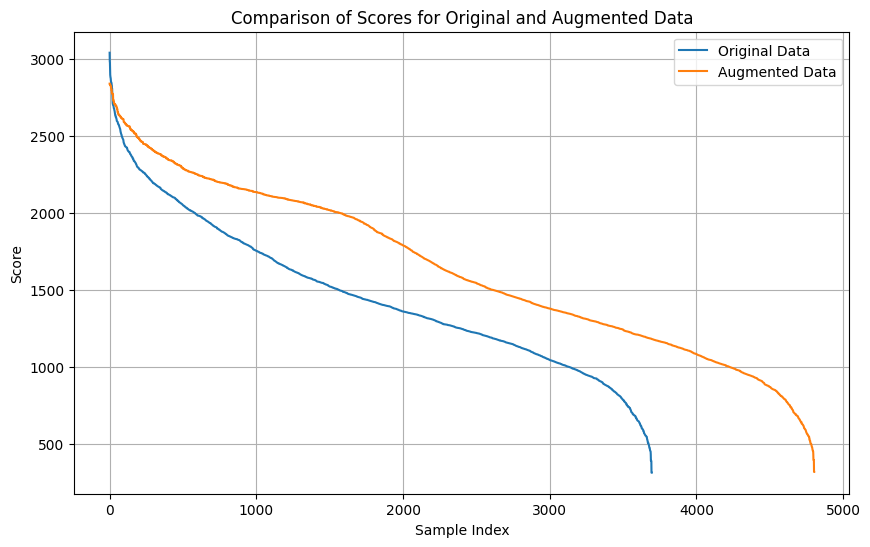

In [9]:
import matplotlib.pyplot as plt

# Extract scores from scored_data and scored_augmented_data
scores = [x[1] for x in scored_data]
augmented_scores = [x[1] for x in scored_augmented_data]

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(scores, label='Original Data')
plt.plot(augmented_scores, label='Augmented Data')

# Customize the plot
plt.xlabel('Sample Index')
plt.ylabel('Score')
plt.title('Comparison of Scores for Original and Augmented Data')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

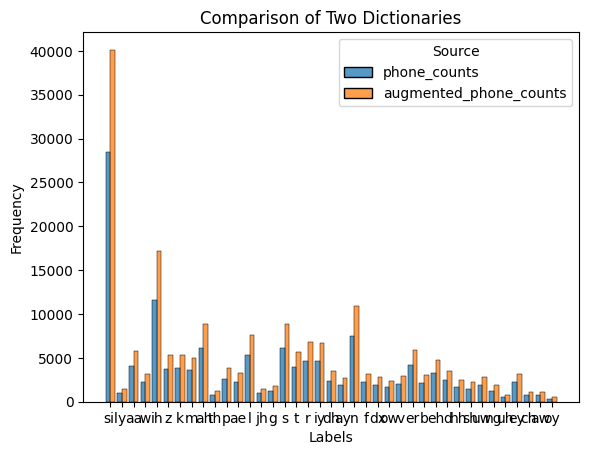

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert dictionaries to DataFrames
df1 = pd.DataFrame(list(phone_counts.items()), columns=['Label', 'Frequency'])
df2 = pd.DataFrame(list(augmented_phone_counts.items()), columns=['Label', 'Frequency'])

# Add a column to identify the source of data
df1['Source'] = 'phone_counts'
df2['Source'] = 'augmented_phone_counts'

# Concatenate the DataFrames
combined_df = pd.concat([df1, df2])

# Create the histogram using seaborn
sns.histplot(data=combined_df, x='Label', hue='Source', weights='Frequency', multiple='dodge', shrink=.8)

# Customize the plot (optional)
plt.title('Comparison of Two Dictionaries')
plt.xlabel('Labels')
plt.ylabel('Frequency')

# Display the plot
plt.show()

In [11]:
l = {i: (augmented_phone_counts[i]-phone_counts[i])/phone_counts[i] for i in augmented_phone_counts.keys()}

In [12]:
l

{'sil': 0.410373546051938,
 'y': 0.4482412060301508,
 'aa': 0.41591846639165253,
 'w': 0.4187725631768953,
 'ih': 0.4747805129970735,
 'z': 0.4579033134166214,
 'k': 0.3900896151818661,
 'm': 0.40773976444195176,
 'ah': 0.4407275089314713,
 'th': 0.5879194630872483,
 'p': 0.47836166924265844,
 'ae': 0.4040139616055846,
 'l': 0.4181547619047619,
 'jh': 0.46594274432379074,
 'g': 0.46851385390428213,
 's': 0.43911917098445596,
 't': 0.4341438703140831,
 'r': 0.456740012817774,
 'iy': 0.4396887159533074,
 'dh': 0.468013468013468,
 'ay': 0.4157187176835574,
 'n': 0.4552218974222695,
 'f': 0.43160270880361173,
 'dx': 0.509656652360515,
 'ow': 0.4379915305505142,
 'v': 0.4844533600802407,
 'er': 0.42580956984050267,
 'b': 0.4199908298945438,
 'eh': 0.4650595056454074,
 'd': 0.421875,
 'hh': 0.4614457831325301,
 'sh': 0.529331514324693,
 'uw': 0.44672131147540983,
 'ng': 0.559016393442623,
 'uh': 0.624,
 'ey': 0.3742844561867019,
 'ch': 0.348780487804878,
 'aw': 0.47802197802197804,
 'oy': 0.

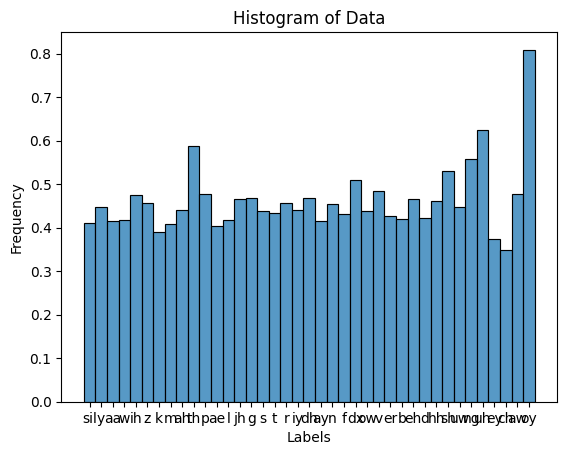

In [13]:
# Convert dictionary to DataFrame
df = pd.DataFrame(list(l.items()), columns=['Label', 'Frequency'])

# Create the histogram using seaborn
sns.histplot(data=df, x='Label', weights='Frequency', discrete=True)

# Customize the plot (optional)
plt.title('Histogram of Data')
plt.xlabel('Labels')
plt.ylabel('Frequency')

# Display the plot
plt.show()

## Augmentation 1: Speed Perturbation

Factors are taken from recommended values in original paper https://www.danielpovey.com/files/2015_interspeech_augmentation.pdf.

In [14]:
class SpeedPerturber:
    def __init__(self, sample_rate):
        self.sample_rate = sample_rate

    def __call__(self, wav, speed_factor):
        if speed_factor == 1.0:
          return wav, self.sample_rate

        effects = [
            ["speed", str(speed_factor)],
            ["rate", str(self.sample_rate)],
        ]
        perturbed_audio, perturbed_sampling_rate = torchaudio.sox_effects.apply_effects_tensor(wav, self.sample_rate, effects)
        # Check: speed changed in the right way
        assert wav.shape[1] > perturbed_audio.shape[1] if speed_factor > 1 else wav.shape[1] < perturbed_audio.shape[1]
        return perturbed_audio, perturbed_sampling_rate

## Augmentation 2: Noise Addition

In [15]:
!cp -r drive/MyDrive/MLMI2/noise_data -d .

In [16]:
NOISE_PATH = './noise_data/audio/'
noise_files = [os.path.join(NOISE_PATH, file) for file in os.listdir(NOISE_PATH) if file.endswith('.wav')]

In [31]:
class RandomBackgroundNoise:
    def __init__(self, sample_rate, noise_dir, min_snr_db=0, max_snr_db=15):
        self.sample_rate = sample_rate
        self.min_snr_db = min_snr_db
        self.max_snr_db = max_snr_db

        if not os.path.exists(noise_dir):
            raise IOError(f'Noise directory `{noise_dir}` does not exist')
        # find all WAV files including in sub-folders:
        self.noise_files_list = list(pathlib.Path(noise_dir).glob('**/*.wav'))
        if len(self.noise_files_list) == 0:
            raise IOError(f'No .wav file found in the noise directory `{noise_dir}`')

    def __call__(self, audio_data):
        random_noise_file = random.choice(self.noise_files_list)
        effects = [
            ['remix', '1'], # convert to mono
            ['rate', str(self.sample_rate)], # resample
        ]
        noise, _ = torchaudio.sox_effects.apply_effects_file(random_noise_file, effects, normalize=True)
        audio_length = audio_data.shape[-1]
        noise_length = noise.shape[-1]
        if noise_length > audio_length:
            offset = random.randint(0, noise_length-audio_length)
            noise = noise[..., offset:offset+audio_length]
        elif noise_length < audio_length:
            noise = torch.cat([noise, torch.zeros((noise.shape[0], audio_length-noise_length))], dim=-1)

        snr_db = random.randint(self.min_snr_db, self.max_snr_db)
        snr = math.exp(snr_db / 10)
        audio_power = audio_data.norm(p=2)
        noise_power = noise.norm(p=2)
        scale = snr * noise_power / audio_power

        return (scale * audio_data + noise) / 2

## Grid Augmentation (combine transformations)

In [32]:
class ComposeTransform:
  def __init__(self, transforms):
    self.transforms = transforms

  def __call__(self, wav, original_sampling_rate, speed_factor, add_noise):
    if add_noise:
      noisy_wav = self.transforms[0](wav)
    else:
      noisy_wav = wav
    perturbed_wav, perturbed_sampling_rate = self.transforms[1](noisy_wav, speed_factor)
    # Check: sampling rate is same as original
    assert perturbed_sampling_rate == original_sampling_rate
    return perturbed_wav, perturbed_sampling_rate

In [33]:
compose_transform = ComposeTransform([
  RandomBackgroundNoise(sample_rate=16000, noise_dir=NOISE_PATH),
  SpeedPerturber(sample_rate=16000),
])

In [34]:
settings = {
    'speed_factor': [0.9, 1.0, 1.1],
    'noise_ratio': [0.0, 0.2, 0.5],
}

combinations = list(itertools.product(*settings.values()))
setting_comb = [dict(zip(settings.keys(), combination)) for combination in combinations]

In [35]:
!rm -rf synthetic_mfcc

In [36]:
perturbation_paths = {
    '0.9_0.0': [], '0.9_0.2': [], '0.9_0.5': [],
    '1.0_0.0': [], '1.0_0.2': [], '1.0_0.5': [],
    '1.1_0.0': [], '1.1_0.2': [], '1.1_0.5': [],
}

for idx, sample_path in tqdm(enumerate(train_wav_paths)):

  for setting in setting_comb:

    # Ignore original dataset
    # if setting['speed_factor'] == 1.0 and setting['noise_ratio'] == 0.0:
    #   continue

    # Deterministically decide to add noise to 0%, 20% or 50% of synthetic data
    if setting['noise_ratio'] == 0.0:
      add_noise = False
    elif setting['noise_ratio'] == 0.2:
      add_noise = True if (idx % 10 == 1 or idx % 10 == 3) else False
    else:
      add_noise = True if (idx % 10 < 5) else False

    # Get transformed audio
    wav, original_sampling_rate = torchaudio.load(sample_path)
    transformed_audio, transformed_sampling_rate = compose_transform(wav, original_sampling_rate, setting['speed_factor'], add_noise)

    # Get normalized MFCCs
    mfcc = torchaudio.compliance.kaldi.fbank(transformed_audio)
    mfcc_mean = torch.mean(mfcc, dim=0, keepdim=True)
    mfcc_std = torch.std(mfcc, dim=0, keepdim=True) + 1e-6
    mfcc_norm = (mfcc - mfcc_mean) / mfcc_std
    assert bool(-10000 < mfcc_norm[0][0] < 100000), transformed_audio

    # Save synthetic data
    id = f"{setting['speed_factor']}_{setting['noise_ratio']}"
    new_path, file_name = f"synthetic_mfcc/mfcc_{id}/{'/'.join(sample_path.split('/')[1:-1])}", sample_path.split('/')[-1].replace('.WAV', '.pt')
    os.makedirs(new_path, exist_ok = True)
    torch.save(mfcc_norm, f"{new_path}/{file_name}")
    perturbation_paths[id].append(f"{new_path}/{file_name}")

3696it [06:35,  9.34it/s]


In [37]:
!zip -r drive/MyDrive/MLMI2/proc_data/augmented_data/synthetic_mfcc.zip synthetic_mfcc -q

#### Save json pointing-data files

In [38]:
dataset_settings = [
    [[1.0, 0.0]],
    [[1.0, 0.0], ['HALF', 0.0]],
    [[1.0, 0.0], [0.9, 0.0], [1.1, 0.0]],

    [[1.0, 0.2]],
    [[1.0, 0.2], ['HALF', 0.2]],
    [[1.0, 0.2], [0.9, 0.2], [1.1, 0.2]],

    [[1.0, 0.5]],
    [[1.0, 0.5], ['HALF', 0.5]],
    [[1.0, 0.5], [0.9, 0.5], [1.1, 0.5]],
]

In [39]:
for setting in dataset_settings:

  new_data = []

  for idx, sample in enumerate(data):
    for perturbation in setting:
      speed_factor, noise_ratio = perturbation

      # Get half slow half fast data on 200% dataset
      if speed_factor == 'HALF':
        speed_factor = 0.9 if idx < len(data)//2 else 1.1

      new_sample = sample.copy()
      del new_sample['wav']
      del new_sample['duration']
      new_sample['mfcc_path'] = f"synthetic_mfcc/mfcc_{speed_factor}_{noise_ratio}/{sample['wav'].replace('wav/TRAIN/', '').replace('.WAV', '.pt')}"
      new_data.append(new_sample)

  # Save json training data to disk
  with open(f'drive/MyDrive/MLMI2/proc_data/augmented_data/json/synthetic_train_x{len(setting)}_noise={noise_ratio}.json', 'w') as f:
    json.dump(new_data, f, indent=4)
